<h1><center>Variational Autoencoder</center></h1>
This is my implementation of Kingma's variational autoencoder. I tried to be as flexible with the implementation as I could, so different distribution could be used for:
1. The approximate posterior - *encoder* - $q_{\phi}\left(z|x\right)$
2. The conditional likelihood of the data - *decoder* - $p_{\theta}\left(x|z\right)$
3. The prior on the latent space $p\left(z\right)$. Note that this implementation doesn't support a parametrized prior [yet ;)]

This Notebook relies on `Keras` and `ipywidgets` packages.

## Notebook Setup
first we setup our notebook so we can view the visualizations inlined

In [1]:
import matplotlib.pyplot as plt

# configure matplotlib
%matplotlib inline
plt.rcParams['figure.figsize'] = (13.5, 13.5) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'

%load_ext autoreload
%autoreload 2

## Framework Definition
Now we define our VAE model as an abstract class. In order to instantiate a VAE we will only need to implement the abstarct methods, and we are done!

### Custom Layers
First, we define a couple of custom layers we need for the model

In [2]:
import abc
import numpy as np

from keras.models import Model, Input
from keras.layers import Dense, Reshape, Flatten, Lambda, Layer
import keras.backend as K


def to_list(obj):
    return obj if isinstance(obj, list) else [obj]


class LatentSampling(Layer):
    '''Custom layer used to sample in the latent space and add the kld loss to the objective
    '''
    def __init__(self, output_dim, sampling_func, kld_func, **kwargs):
        self.output_dim = output_dim
        self.sample = sampling_func
        self.kld = kld_func
        super(LatentSampling, self).__init__(**kwargs)

    def call(self, inputs):
        eps, posterior_params = inputs[0], inputs[1:]
        z = self.sample(eps, *posterior_params)
        kld_loss = self.kld(z, *posterior_params)
        # Add the KL divergence loss of this batch to the objective
        self.add_loss(K.mean(kld_loss), inputs=inputs)
        return z

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)
    
class DataSampling(Layer):
    '''Custom layer used to sample in the data space and add the reconstruction loss to the objective
    '''
    def __init__(self, output_dim, sampling_func, reconstruction_loss_func, **kwargs):
        self.output_dim = output_dim
        self.sample = sampling_func
        self.reconstruction_loss = reconstruction_loss_func
        super(DataSampling, self).__init__(**kwargs)

    def call(self, inputs):
        x, likelihood_params = inputs[0], inputs[1:]
        x_reconstructed = self.sample(*likelihood_params)
        reconstruction_loss = self.reconstruction_loss(x, *likelihood_params)
        # Add the reconstruction loss for this batch to the objective
        self.add_loss(K.mean(reconstruction_loss), inputs=inputs)
        return x_reconstructed

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)


Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: TITAN X (Pascal) (CNMeM is enabled with initial size: 95.0% of memory, cuDNN 5110)


### Abstract Variational Autoencoder
Then, we define our main class

In [3]:
class AbstractVariationalAutoencoder(abc.ABC):   
    def __init__(self, data_shape, latent_dim):
        self.data_shape = data_shape
        self.latent_dim = latent_dim
        self._encoder = self._create_encoder()  # Outputs posterior parameters
        self._decoder = self._create_decoder()  # Outputs to conditional likelihood parameters
        models = self._create_vae()
        self._vae = models[0]
        self._encoder_to_latent_space = models[1]
        self._decoder_to_data_space = models[2]
        
        
    ####################
    # Abstract Methods #
    ####################
    @abc.abstractmethod
    def _create_encoder(self):
        '''Create and return an encoder keras model with data as input, and the posterior parameters as output(s)'''
        raise NotImplementedError()
    
    @abc.abstractmethod
    def _create_decoder(self):
        '''Create and return a decoder keras model with latent vector as input,
        and the conditional likelihood parameters as output(s)'''
        raise NotImplementedError()
        
    @abc.abstractmethod
    def _sample_eps(self, eps_shape):
        '''Return a sample from the eplison distribution (input noise)'''
        raise NotImplementedError()

    @abc.abstractmethod
    def _sample_latent_z(self, eps, *posterior_params):
        '''Return a sample with `eps` noise as input and according to the posterior parameters'''
        raise NotImplementedError()

    @abc.abstractmethod
    def _kl_divergence(self, z, *posterior_params):
        '''Compute the KL divergence from the latent prior to the approximate posterior'''
        raise NotImplementedError()
    
    @abc.abstractmethod
    def _sample_data(self, *likelihood_params):
        '''return a sample according to the likelihood parameters'''
        raise NotImplementedError()
        
    @abc.abstractmethod
    def _negative_expected_log_likelihood(self, x, *likelihood_params):
        '''Compute the negative expected log likelihood (a.k.a reconstruction loss) from the likelihood parameters'''
        raise NotImplementedError()
        
    #####################################################    
    
    def _create_vae(self):
        # Encoder
        data_input = Input(shape=self.data_shape, name='data')
        posterior_params = self.encoder(data_input)
        
        # Sampling
        noise_input = Input(shape=(self.latent_dim,), name='noise')
        posterior_params = to_list(posterior_params)
        latent_sample = LatentSampling(self.latent_dim, 
                                       self._sample_latent_z, self._kl_divergence)([noise_input] + posterior_params)
        
        # Decoder
        likelihood_params = self.decoder(latent_sample)
        likelihood_params = to_list(likelihood_params)
        reconstructed_x = DataSampling(self.data_shape, 
                                       self._sample_data, 
                                       self._negative_expected_log_likelihood)([data_input] + likelihood_params)
        
        # Create models
        vae = Model([data_input, noise_input], reconstructed_x)
        
        encoder_params = to_list(self.encoder(data_input))
        encoded_z = Lambda(lambda params: self._sample_latent_z(*params), 
                           output_shape=(self.latent_dim,))([noise_input] + encoder_params)
        encoder_to_latent_space = Model([data_input, noise_input], encoded_z)
        
        latent_input = Input(shape=(self.latent_dim,), name='latent')
        decoder_params = to_list(self.decoder(latent_input))
        decoder_out = Lambda(lambda params: self._sample_data(*params), output_shape=self.data_shape)(decoder_params)
        decoder_to_data_space = Model(latent_input, decoder_out)
        
        return vae, encoder_to_latent_space, decoder_to_data_space
            
    # We define the encoder and decoder as read-only properties
    @property
    def encoder(self):
        return self._encoder
    
    @property
    def decoder(self):
        return self._decoder
    
    def encode(self, x, **kwargs):
        noise = self._sample_eps(eps_shape=(len(x), self.latent_dim))
        return self._encoder_to_latent_space.predict({'data': x, 'noise': noise}, **kwargs)
    
    def decode(self, z, **kwargs):
        return self._decoder_to_data_space.predict(z, **kwargs)
    
    def compile(self, *args, **kwargs):
        '''Invoke the compile method of a keras model'''
        return self._vae.compile(*args, **kwargs)
    
    def fit(self, x, x_val=None, **kwargs):
        '''Invoke the fit method of a keras model, with `x` as the data, and `eps` as the input noise.
        '''
        if x_val is None:
            validation_data = None
        else:
            validation_noise = self._sample_eps(eps_shape=(len(x_val), self.latent_dim))
            validation_data = ({'data': x_val, 'noise': validation_noise}, None)
        noise = self._sample_eps(eps_shape=(len(x), self.latent_dim))
        return self._vae.fit(x={'data': x, 'noise': noise}, validation_data=validation_data, **kwargs)


## VAE Instance Examples
Now it's time to build some concrete examples. We will only use a standard Gaussian as the prior, and a multivariate Gaussian with diagonal covariance as the approximate posterior, so let's create a derived abstract class that defines these.

In [4]:
class AbstractGaussianPriorPosteriorVAE(AbstractVariationalAutoencoder):
    def _create_encoder(self):
        x = Input(shape=self.data_shape)
        h = Flatten()(x)
        h = Dense(200, activation='relu')(h)
        mu = Dense(self.latent_dim)(h)
        log_var = Dense(self.latent_dim)(h)
        return Model(inputs=x, outputs=[mu, log_var])
    
    def _sample_eps(self, eps_shape):
        return np.random.normal(size=eps_shape)
    
    def _sample_latent_z(self, eps, *posterior_params):
        mu, log_var = posterior_params
        return mu + K.exp(.5 * log_var) * eps
    
    def _kl_divergence(self, z, *posterior_params):
        mu, log_var = posterior_params
        return -0.5 * K.sum(1. + log_var - K.square(mu) - K.exp(log_var), axis=-1)
   

### Bernoulli VAE
We will first assume $p_{\theta}\left(x|z\right)$ is a multivariate Bernoulli:

In [5]:
class GaussianPriorPosteriorBernoulliVAE(AbstractGaussianPriorPosteriorVAE):
    def _create_decoder(self):
        z = Input(shape=(self.latent_dim,))
        h = Dense(200, activation='relu')(z)
        output_len = np.prod(self.data_shape)

        p = Dense(output_len, activation='sigmoid')(h)
        p = Reshape(self.data_shape)(p)
        return Model(inputs=z, outputs=p)
        
    def _sample_data(self, *likelihood_params):
        '''We output `p` (the expectation) instead of really sampling'''
        p = likelihood_params[0]
        return p
        
    def _negative_expected_log_likelihood(self, x, *likelihood_params):
        p = likelihood_params[0]
        loss = K.batch_flatten(K.binary_crossentropy(p, x))
        return K.sum(loss, axis=-1)

That's it! We just need to pick a data-set and train an instance of the VAE. We will pick the well-known MNIST data-set first, create some noise as the $\epsilon$ noise, and fit the model:

In [6]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype(np.float32) / 255.
x_test = x_test.astype(np.float32) / 255.

mnist_data_shape = x_train.shape[1:]
mnist_latent_dim = 2
batch_size = 100
num_epochs = 50

ber_vae = GaussianPriorPosteriorBernoulliVAE(mnist_data_shape, mnist_latent_dim)
ber_vae.compile('adam', loss=None)

ber_vae.fit(x_train, x_test,
            batch_size=batch_size,
            epochs=num_epochs,
            shuffle=True,
            verbose=2)  #  this will not hang the notebook


/home/izikgo/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:105: UserWarning: Output "data_sampling_1" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "data_sampling_1" during training.


Train on 60000 samples, validate on 10000 samples
Epoch 1/50
0s - loss: 203.9255 - val_loss: 176.3230
Epoch 2/50
0s - loss: 171.9116 - val_loss: 169.1065
Epoch 3/50
0s - loss: 167.6307 - val_loss: 166.9313
Epoch 4/50
0s - loss: 165.5078 - val_loss: 165.0010
Epoch 5/50
0s - loss: 163.7068 - val_loss: 163.3356
Epoch 6/50
0s - loss: 162.1334 - val_loss: 161.9797
Epoch 7/50
0s - loss: 160.7301 - val_loss: 160.6541
Epoch 8/50
0s - loss: 159.5058 - val_loss: 159.6319
Epoch 9/50
0s - loss: 158.4893 - val_loss: 158.7281
Epoch 10/50
0s - loss: 157.6016 - val_loss: 157.9914
Epoch 11/50
0s - loss: 156.8344 - val_loss: 157.4590
Epoch 12/50
0s - loss: 156.1385 - val_loss: 156.8540
Epoch 13/50
0s - loss: 155.6066 - val_loss: 156.4385
Epoch 14/50
0s - loss: 155.0529 - val_loss: 156.0883
Epoch 15/50
0s - loss: 154.6130 - val_loss: 155.7392
Epoch 16/50
0s - loss: 154.2361 - val_loss: 155.8313
Epoch 17/50
0s - loss: 153.8454 - val_loss: 155.1524
Epoch 18/50
0s - loss: 153.4890 - val_loss: 155.0060
Epoch

Now that we have a our trained model, lets look at how the latent space looks like:

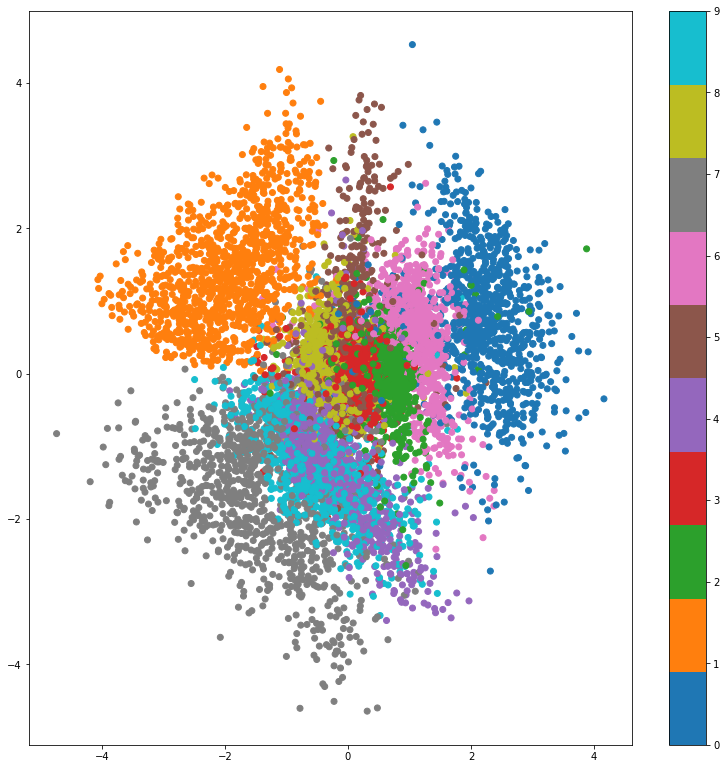

In [7]:
x_test_encoded = ber_vae.encode(x_test)
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test, cmap='Vega10')
plt.colorbar()
plt.show()


As expected, the VAE managed to devide the latent space to roughly 10 sections, each corresponding to a different digit. The overall shape however resembles a standaed Gaussian due to the KL divergence regularizing term.

We can visualize the 2D latent space by decoding from it. You can see that the positions fit the labeled areas in the previous plot.

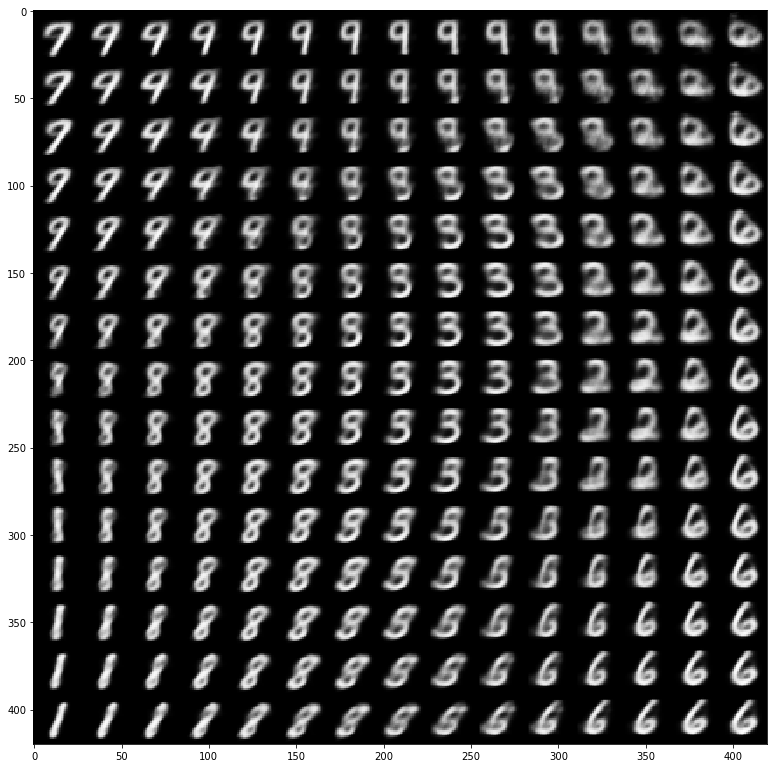

In [8]:
from scipy.stats import norm

# display a 2D manifold of the images
n = 15  # figure with 15x15 images
rows, cols = mnist_data_shape
figure = np.zeros((rows * n, cols * n))
# linearly spaced coordinates on the unit square are transformed through the inverse CDF (ppf)
# of the Gaussian to produce values of the latent variables z, since the prior of the latent space
# is Gaussian
grid_x = norm.ppf(np.linspace(0.1, 0.9, n))
grid_y = norm.ppf(np.linspace(0.1, 0.9, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = ber_vae.decode(z_sample)
        img = x_decoded[0].reshape(rows, cols)
        figure[i * rows: (i + 1) * rows,
               j * cols: (j + 1) * cols] = img

plt.imshow(figure, cmap='Greys_r')
plt.show()

### Gaussian VAE
Another example we can try is to assume $p_{\theta}\left(x|z\right)$ is a Gaussian with diagonal covariance:

In [12]:
class FullyGaussianVAE(AbstractGaussianPriorPosteriorVAE):
    def _create_decoder(self):
        z = Input(shape=(self.latent_dim,))
        h = Dense(200, activation='relu')(z)
        output_len = np.prod(self.data_shape)

        mu = Dense(output_len, activation='sigmoid')(h)  # constrain gaussian mean to [0, 1] like the inputs pixels
        mu = Reshape(self.data_shape)(mu)

        log_var_clip_val = 5
        # we clip the log variance to avoid numerical issues (NaNs in the loss)
        log_var = Dense(output_len, activation=lambda v: K.clip(v, -log_var_clip_val, log_var_clip_val))(h)
        log_var = Reshape(self.data_shape)(log_var)
        return Model(inputs=z, outputs=[mu, log_var])
        
    def _sample_data(self, *likelihood_params):
        '''We output `mu` (the expectation) instead of really sampling'''
        mu, log_var = likelihood_params
        return mu
        
    def _negative_expected_log_likelihood(self, x, *likelihood_params):
        mu, log_var = likelihood_params
        x_prec = K.exp(-log_var)
        x_diff = x - mu
        x_power = -0.5 * K.square(x_diff) * x_prec
        log_likelihood = -0.5 * (log_var + np.log(2 * np.pi)) + x_power
        log_likelihood = K.batch_flatten(log_likelihood)
        return -K.sum(log_likelihood, axis=-1)


We will work with the Frey Face dataset for the fully gaussian VAE, as the original paper

In [13]:
import os
from urllib.request import urlopen
from scipy.io import loadmat

def get_frey_face():
    url = "http://www.cs.nyu.edu/~roweis/data/frey_rawface.mat"
    data_filename = os.path.basename(url)
    if not os.path.exists(data_filename):
        f = urlopen(url)
        print("Downloading data file " + url + " ...")

        with open(os.path.basename(url), "wb") as local_file:
            local_file.write(f.read())
        print("Done.")
    else:
        print("Data file {} already exists.".format(data_filename))

    # reshape data for later convenience
    img_rows, img_cols = 28, 20
    ff = loadmat(data_filename, squeeze_me=True, struct_as_record=False)
    ff = ff["ff"].T.reshape((-1, img_rows, img_cols))

    X_train = ff[:1800]
    X_val = ff[1800:]
    return X_train, X_val


In [14]:
x_train, x_test = get_frey_face()
x_train = x_train.astype(np.float32) / 255.
x_test = x_test.astype(np.float32) / 255.

ff_data_shape = x_train.shape[1:]
ff_latent_dim = 2
batch_size = 100
num_epochs = 30

gauss_vae = FullyGaussianVAE(ff_data_shape, ff_latent_dim)
gauss_vae.compile('adam', loss=None)

gauss_vae.fit(x_train, x_test,
              batch_size=batch_size,
              epochs=num_epochs,
              shuffle=True,
              verbose=2)

Data file frey_rawface.mat already exists.


/home/izikgo/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:105: UserWarning: Output "data_sampling_3" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "data_sampling_3" during training.


Train on 1800 samples, validate on 165 samples
Epoch 1/30
0s - loss: 292.6033 - val_loss: -8.8821e+01
Epoch 2/30
0s - loss: -3.2591e+02 - val_loss: -3.8710e+02
Epoch 3/30
0s - loss: -4.7884e+02 - val_loss: -4.4093e+02
Epoch 4/30
0s - loss: -5.0966e+02 - val_loss: -4.5598e+02
Epoch 5/30
0s - loss: -5.1987e+02 - val_loss: -4.5865e+02
Epoch 6/30
0s - loss: -5.2593e+02 - val_loss: -4.5614e+02
Epoch 7/30
0s - loss: -5.3171e+02 - val_loss: -4.5913e+02
Epoch 8/30
0s - loss: -5.3391e+02 - val_loss: -4.7323e+02
Epoch 9/30
0s - loss: -5.4161e+02 - val_loss: -5.1013e+02
Epoch 10/30
0s - loss: -5.5662e+02 - val_loss: -5.4708e+02
Epoch 11/30
0s - loss: -5.6929e+02 - val_loss: -5.7029e+02
Epoch 12/30
0s - loss: -5.7758e+02 - val_loss: -5.7516e+02
Epoch 13/30
0s - loss: -5.8153e+02 - val_loss: -5.7633e+02
Epoch 14/30
0s - loss: -5.8691e+02 - val_loss: -5.7907e+02
Epoch 15/30
0s - loss: -5.8995e+02 - val_loss: -5.8010e+02
Epoch 16/30
0s - loss: -5.9279e+02 - val_loss: -5.7963e+02
Epoch 17/30
0s - loss

We can view the learned latent space:

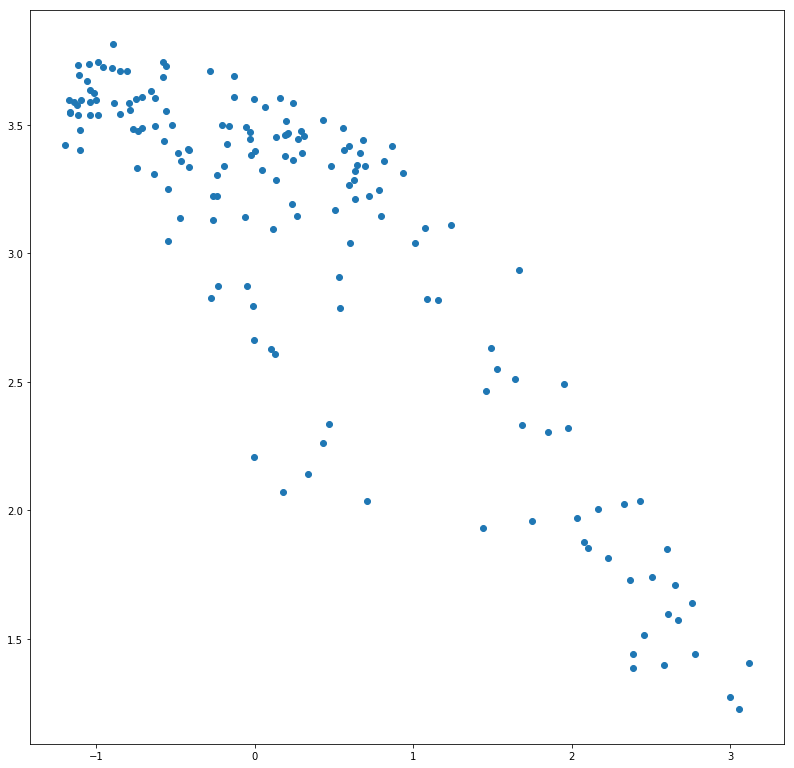

In [15]:
x_test_encoded = gauss_vae.encode(x_test)
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1])
plt.show()

Our VAE in the on the Frey Face dataset, has suceeded in learning a powerfull 2D representation, where one dimension represents the expression (sad/happy), and the other represents the pose of the face! You can use this interactive demo to witness this 

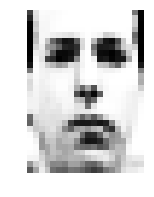

In [16]:
from ipywidgets import FloatSlider, interact

humour = FloatSlider(min=-10, max=10, step=0.5, value=0)
pose = FloatSlider(min=-10, max=10, step=0.5, value=0)

@interact(pose=pose, humour=humour)
def do_thumb(humour, pose):
    z_sample = np.array([[humour, pose]])
    x_decoded = gauss_vae.decode(z_sample)
    face = x_decoded[0].reshape(ff_data_shape)
    plt.figure(figsize=(3, 3))
    ax = plt.subplot(111)
    ax.imshow(face, cmap='Greys_r')
    plt.axis("off")